In [1]:
import sys
import os
repo_dir = os.path.dirname(os.getcwd())
sys.path.append(repo_dir)

In [2]:
from utils.bins_samplers import GaussianQMCSampler
from models.cm import ContinuousMixture
from torch.utils.data import DataLoader
from utils.datasets import load_debd
import pytorch_lightning as pl
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpus = None if device == 'cpu' else 1
print(device)

cuda


## Load datasets and create dataloaders

In [3]:
# Load datasets
_, valid, test = load_debd('binarized_mnist')

# Create loaders - if you run OOM, you may want to decrease the batch size
batch_size = 64
valid_loader = DataLoader(valid, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

## Load model (you should specify a path!)

In [4]:
# Warning: The model should be MLP based

path = '../logs/gen_bmnist/FFM/latent_dim_16/num_bins_16384/version_0/checkpoints/best_model_valid-epoch=63.ckpt'
model = ContinuousMixture.load_from_checkpoint(path).to(device)
model.missing = False
model.eval(); # semi-colon to prevent printing model architecture

/home2/s3313093/venvs/my_env/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.


## Evaluate LLs 

In [7]:
# if you run OOM, you may want to use n_chunks
model.n_chunks = 32
n_bins_list = [2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14]
            
for n_bins in n_bins_list:
    model.sampler.n_bins = n_bins
    z, log_w = model.sampler(seed=42)

    # print('Computing validation LL using %d bins..' % n_bins)
    # print(model.eval_loader(valid_loader, z, log_w, device=device).mean().item())
    print('Computing test LL using %d bins..' % n_bins)
    print(model.eval_loader(test_loader, z, log_w, device=device).mean().item() / 784)

Computing test LL using 128 bins..
-0.23377040940888075
Computing test LL using 256 bins..
-0.214372595962213
Computing test LL using 512 bins..
-0.1966695785522461
Computing test LL using 1024 bins..
-0.18374448893021564
Computing test LL using 2048 bins..
-0.17313492054841956
Computing test LL using 4096 bins..
-0.1647652022692622
Computing test LL using 8192 bins..
-0.15816816991689253
Computing test LL using 16384 bins..
-0.15315002324629803


## Draw 16 samples from CMs of factorisations (Only works for CMs of factorisations)

torch.Size([16, 784])
torch.Size([16, 784])


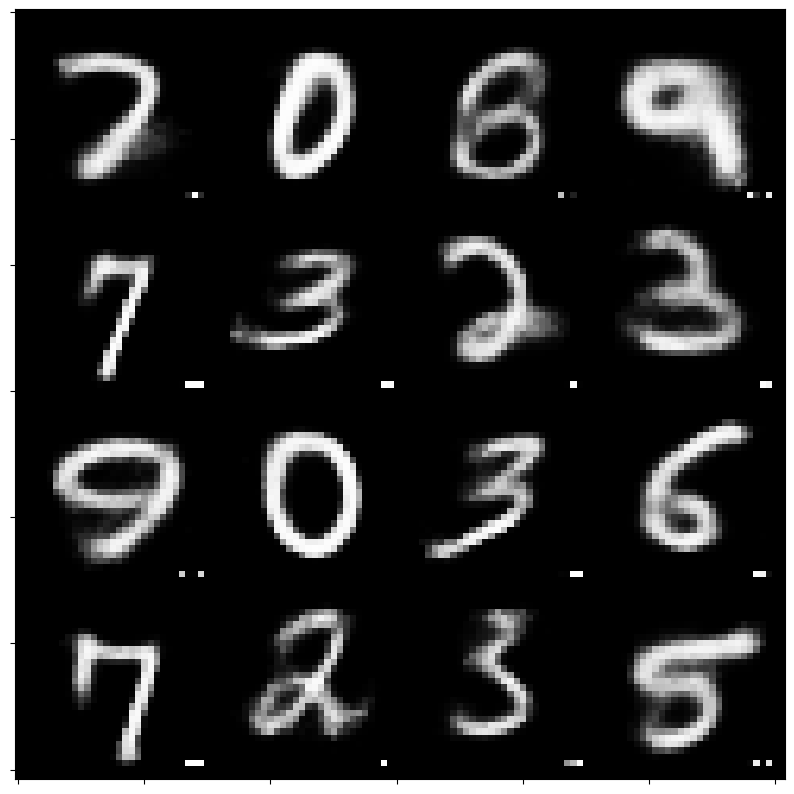

In [25]:
latent_dim = model.sampler.latent_dim
print(model.decoder.net(torch.randn(16, latent_dim).to(device)).detach().cpu().shape)
samples = model.decoder.net(torch.randn(16, latent_dim).to(device)).sigmoid().detach().cpu()

print(samples.shape)

grid_img = torchvision.utils.make_grid(samples.view(16, 1, 28, 28), nrow=4)
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0));
ax.set_yticklabels([]);
ax.set_xticklabels([]);

## Compile a mixture and sample (Only works for CMs of factorisations)

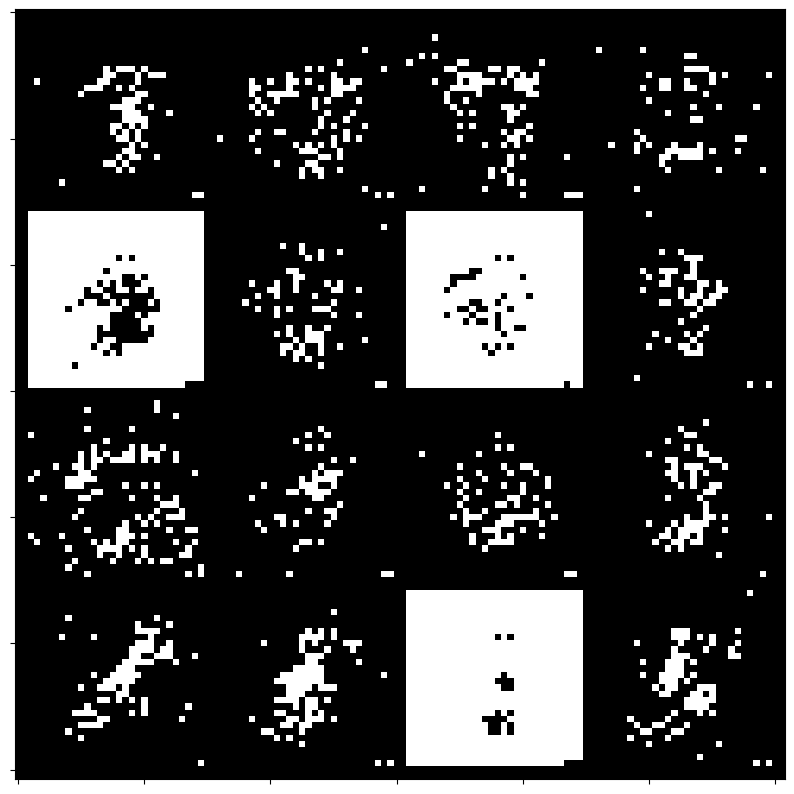

In [16]:
from models.mixtures import BernoulliMixture

model.sampler.n_bins = n_components = 512
z, log_w = model.sampler(seed=42)
mixture = BernoulliMixture(logits_p=model.decoder.net(z.to(device)), logits_w=log_w).to(device)

# return_p=False results in binary images, unsure why
samples = mixture.sample(16, return_p=False).detach().cpu()

grid_img = torchvision.utils.make_grid(samples.view(16, 1, 28, 28), nrow=4)
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0));
ax.set_yticklabels([]);
ax.set_xticklabels([]);

In [35]:
from torchvision import datasets

# download MNIST into data directory (if needed)
mnist_train_and_val = datasets.MNIST(root="../data", train=True, download=True)
mnist_test = datasets.MNIST(root="../data", train=False, download=True)

# assign labels
labels_mnist_train_and_val = mnist_train_and_val.targets
labels_mnist_test = mnist_test.targets

# convert datasets to tensors
mnist_train_and_val = mnist_train_and_val.data.view(60_000, 784).float()
mnist_test = mnist_test.data.view(10_000, 784).float()

# ========== experimation START

for idx in range(mnist_train_and_val.shape[0]):
    label = labels_mnist_train_and_val[idx]
    temp = 255 * torch.tensor([int(d) for d in bin(label)[2:].zfill(4)]).float()
    mnist_train_and_val[idx][-4:] = temp

# ========== experimation END

# define train, validation and test (binarised)
X_train = (mnist_train_and_val[0:50_000] / 255 >= 0.5).float()
X_val   = (mnist_train_and_val[50_000::] / 255 >= 0.5).float()
X_test  = (mnist_test / 255 >= 0.5).float()

y_train = labels_mnist_train_and_val[0:50_000]
y_val   = labels_mnist_train_and_val[50_000::]
y_test  = labels_mnist_test

# load data into data loaders
# if you run OOM, you may want to decrease the batch size
batch_size = 128
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(X_val  , batch_size=batch_size)
test_loader = DataLoader(X_test, batch_size=batch_size)

# AS ABOVE BUT WITH LATENT OPTIMISATION
from models.lo import bins_lo, fast_bins_lo
from models.mixtures import BernoulliMixture

model.sampler.n_bins = n_bins = 2048
# z, log_w = model.sampler(seed=42)
z, log_w_init = bins_lo(model, n_bins, train_loader, valid_loader, lr=1e-3, max_epochs=200, progress_bar=False, device=device)

Epoch 1/200, Train: 117.9168, Validation: 112.6161, Patience counter: 0.0000
Epoch 2/200, Train: 101.4308, Validation: 111.8655, Patience counter: 0.0000
Epoch 3/200, Train: 107.4443, Validation: 111.5282, Patience counter: 0.0000
Epoch 4/200, Train: 112.4138, Validation: 111.2351, Patience counter: 0.0000
Epoch 5/200, Train: 109.8828, Validation: 111.0633, Patience counter: 0.0000
Epoch 6/200, Train: 103.8401, Validation: 110.9445, Patience counter: 0.0000
Epoch 7/200, Train: 102.5329, Validation: 110.8416, Patience counter: 0.0000
Epoch 8/200, Train: 104.0079, Validation: 110.7080, Patience counter: 0.0000
Epoch 9/200, Train: 105.1230, Validation: 110.6587, Patience counter: 0.0000
Epoch 10/200, Train: 106.1926, Validation: 110.6213, Patience counter: 0.0000
Epoch 11/200, Train: 108.1754, Validation: 110.5297, Patience counter: 0.0000
Epoch 12/200, Train: 107.2248, Validation: 110.4758, Patience counter: 0.0000
Epoch 13/200, Train: 102.0300, Validation: 110.4176, Patience counter: 0.

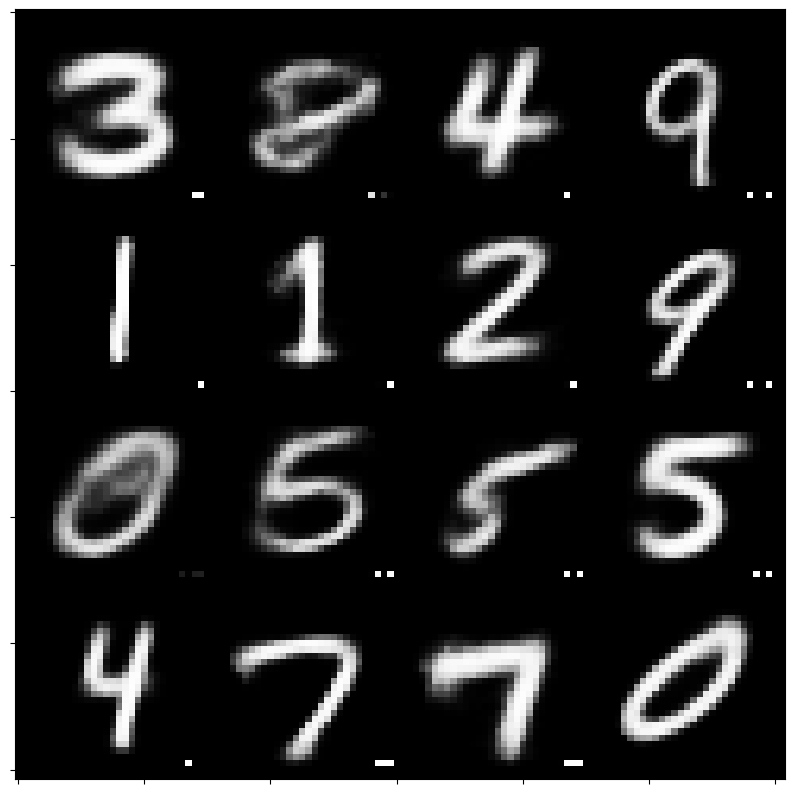

In [104]:
mixture = BernoulliMixture(logits_p=model.decoder.net(z.to(device)), logits_w=log_w).to(device)

# return_p=False results in binary images, unsure why
samples = mixture.sample(16, return_p=True).detach().cpu()

grid_img = torchvision.utils.make_grid(samples.view(16, 1, 28, 28), nrow=4)
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0));
ax.set_yticklabels([]);
ax.set_xticklabels([]);

## Sample from CM of CLTs (Only works for CMs of CLTs)

In [ ]:
from deeprob.spn.structure.cltree import BinaryCLT
clt = BinaryCLT(list(range(784)), tree=model.decoder.tree.numpy())

mask = [True, False] * 784

In [ ]:
print(latent_dim)
param = model.decoder.net(torch.randn(1, latent_dim).to(device)).sigmoid().detach().cpu()[0]
r = param.view(784, 2).repeat_interleave(2, 0)
r[mask] = 1 - r[mask]
r[clt.root * 2][1] = r[clt.root * 2][0]
r[clt.root * 2 + 1][1] = r[clt.root * 2 + 1][0]
clt.params = r.view(784, 2, 2).permute(0, 2, 1).log().numpy()

In [ ]:
samples = torch.Tensor(clt.sample(np.nan * np.zeros((16, 784))))
grid_img = torchvision.utils.make_grid(samples.view(16, 1, 28, 28), nrow=4)
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0));
ax.set_yticklabels([]);
ax.set_xticklabels([]);